# sst-nhf feedback : 

Computes net surface heat flux anomalies (NHFA; sum of latent and sensible heat fluxes and longwave and shortwave radiations) regressed onto surface temperature anomalies (SSTA) both in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux 1979-2018 (main)

NHF: OAFlux-ISCCP 1984-2009, DEEP-C 1985-2016, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023
SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [3]:
# model_select = "ACCESS-CM2"

model_ts_datasets = { 
"ACCESS-CM2": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    # timerange="19790101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
)}
model_ts_datasets["ACCESS-CM2"].add_supplementary(short_name='areacello', mip='Ofx')

model_ts = {name: dataset.load() for name, dataset in model_ts_datasets.items()}

In [2]:
model_hfls_datasets = { 
"ACCESS-CM2": 
    Dataset(
    short_name='hfls',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    # timerange="19790101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
)}

model_hfls_datasets["ACCESS-CM2"].add_supplementary(short_name='areacella', mip='fx')

#rest variables
model_other = {}
for cvar in ['hfss','rlds','rlus','rsds','rsus']:
    
    model_other[cvar] = model_hfls_datasets["ACCESS-CM2"].copy(short_name=cvar)

# load cubes, formula nhf


In [4]:
model_hfls = {name: dataset.load() for name, dataset in model_hfls_datasets.items()}
model_rest = {name: dataset.load() for name, dataset in model_other.items()}

 hfls: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/hfls/gn/v20191108/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
 hfls: attribute positive not present
loaded from file 
 hfss: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/hfss/gn/v20191108/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
 hfss: attribute positive not present
loaded from file 
 rlds: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/rlds/gn/v20191108/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
 rlds: attribute positive not present
loaded from file 
 rlus: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/rlus/gn/v20191108/rlus_Amon_ACC

In [6]:
print(model_hfls['ACCESS-CM2'].data.max(), model_hfls['ACCESS-CM2'].data.mean())
model_rest
test = - model_hfls['ACCESS-CM2']
test.data.max() , test.data.mean(), test.data.min()

530.4982 67.73716


(55.935913, -67.7371632996633, -530.4982)

In [8]:
# nhf = -*hfls* -hfss + rlds - rlus + rsds - rsus #if 'd' make positive
model_nhf = - model_hfls['ACCESS-CM2'] - model_rest['hfss'] + model_rest['rlds']- model_rest['rlus']+ model_rest['rsds']- model_rest['rsus']

In [9]:
obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}

obs_nhf_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='hfds',
     dataset='ERA-Interim',
     mip="Omon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [10]:
obs_tos = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_nhf = {name: dataset.load() for name, dataset in obs_nhf_datasets.items()}

In [11]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [12]:
def east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}

    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **nino3_region)
    # cube = detrend(cube, dimension="time", method="linear")
    cube = area_statistics(cube, operator='mean')
    cube = anomalies(cube, period="full")
    
    return cube


In [13]:
model_ts_prep = {name: east(dataset) for name, dataset in model_ts.items()}
model_nhf_prep = {'ACCESS-CM2': east(model_nhf)}

In [14]:
obs_tos_prep = {name: east(dataset) for name, dataset in obs_tos.items()}
obs_nhf_prep = {name: east(dataset) for name, dataset in obs_nhf.items()}

## Calculate Linear regression

In [15]:
# scp.LinReg(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data).intcpt

def linreg_1d(nhf_cube, ts_cube):
    B_data = ts_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, nhf_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

# B_data = model_ts_prep["ACCESS-ESM1-5"].data
# B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
# coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, model_nhf_prep["ACCESS-ESM1-5"].data, rcond=None)
# coefs

linreg_1d(obs_nhf_prep["ERA-Interim"], obs_tos_prep["HadISST"])

(-7.302368, 0.18406792)

# Diagnostic Level 1

model  -5.249522 0.12186887
model points  (1980,) (1980,)
W m-2 degC
obs points  (480,) (480,)
28.112056851387024


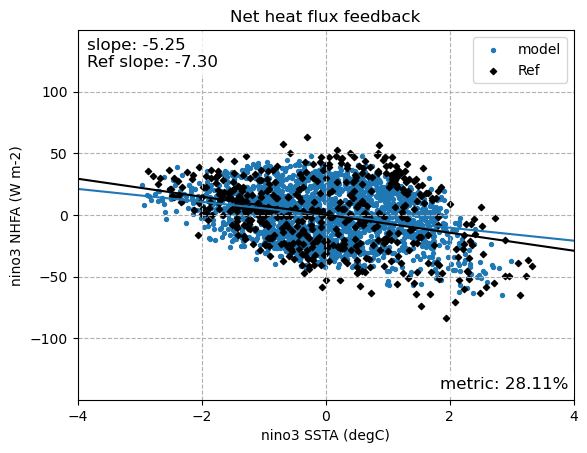

In [69]:
xseq = np.linspace(-4, 4, num=10)

slope, intcpt = linreg_1d(model_nhf_prep["ACCESS-CM2"], model_ts_prep["ACCESS-CM2"])
print('model ', slope, intcpt)
mod_slope = slope
plt.plot(xseq, intcpt+slope*xseq)

slope, intcpt = linreg_1d(obs_nhf_prep["ERA-Interim"], obs_tos_prep["HadISST"])
plt.plot(xseq, intcpt+slope*xseq, color='black')

metric_val = abs((mod_slope-slope)/slope)*100

print('model points ', model_nhf_prep["ACCESS-CM2"].shape, model_ts_prep["ACCESS-CM2"].shape) #scatter plot
print(model_nhf_prep["ACCESS-CM2"].units, model_ts_prep["ACCESS-CM2"].units)

plt.scatter(model_ts_prep["ACCESS-CM2"].data, model_nhf_prep["ACCESS-CM2"].data,label='model', s=8)
yunit = model_nhf_prep["ACCESS-CM2"].units 
xunit = model_ts_prep["ACCESS-CM2"].units

print('obs points ', obs_tos_prep["HadISST"].shape, obs_nhf_prep["ERA-Interim"].shape)
plt.scatter(obs_tos_prep["HadISST"].data, obs_nhf_prep["ERA-Interim"].data, label='Ref', s=10, c='black', marker='D')
plt.xlim(-4,4)
plt.xticks(np.arange(-4,5,2))
plt.ylim(-150,150)
plt.yticks(np.arange(-100,120,50))
plt.grid(linestyle='--')
plt.ylabel(f'nino3 NHFA ({yunit})')
plt.xlabel(f'nino3 SSTA ({xunit})') #°C
plt.legend()
plt.title('Net heat flux feedback')
## text slope
plt.text(0.02, 0.9, f'slope: {mod_slope:.2f} \nRef slope: {slope:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

print(metric_val)

**Figure 1**: scatterplot of sea surface temperature anomalies (SSTA) and net surface heat flux anomalies (NHFA) in the eastern equatorial Pacific (Niño3 averaged), showing the strength of the SST-to-NHF coupling (usually too weak by half; here slightly too strong). The black and blue markers show respectively the reference and the model. The metric is based on the slope of the regression and is the absolute value of the relative difference: abs((model-ref)/ref)*100.

# Diagnostic Level 2

In [70]:
import pandas as pd

def linreg_df(ts, nhf):
    B_data = np.array(ts)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(nhf), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

df = pd.DataFrame({'tos':model_ts_prep["ACCESS-CM2"].data, 'nhf':model_nhf_prep["ACCESS-CM2"].data})
# linreg_df(df.loc[df['tos']<0, 'nhf'], df.loc[df['tos']<0, 'tos'])
# df.loc[df['tos']<0]

def plt_settings(slopes):
    plt.xlim(-4,4)
    plt.xticks(np.arange(-4,5,2))
    plt.ylim(-100,100)
    plt.yticks(np.arange(-100,120,50))
    plt.grid(linestyle='--')
    plt.ylabel(f'nino3 NHFA (W/m2)')
    plt.xlabel(f'nino3 SSTA (°C)') #
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    

In [78]:

def plt_lvl2_subplot(ts_cube, nhf_cube, dataset_label):
    
    df = pd.DataFrame({'tos':ts_cube.data, 'nhf':nhf_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(ts_cube.data, nhf_cube.data, c='k', s=10)
    xseq = np.linspace(-50, 50, num=50)
    slope, intcpt = linreg_df(df['tos'], df['nhf'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-50, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['tos']<0, 'tos'], df.loc[df['tos']<0, 'nhf'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 50, num=50)
    slope, intcpt = linreg_df(df.loc[df['tos']>0, 'tos'], df.loc[df['tos']>0, 'nhf'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

# print(plt.gcf().get_size_inches() * 2) #* plt.gcf().dpi

ACCESS-CM2 shape:  (1980, 2)
[-5.249522, -6.401507, -10.789417]
HadISST_ERA-Interim shape:  (480, 2)
[-7.302368, -14.473135, -14.866123]


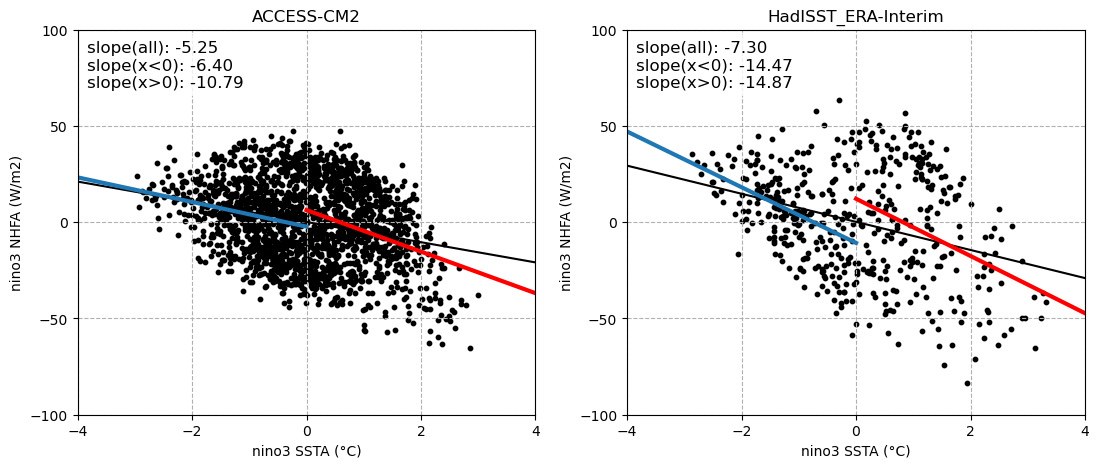

In [77]:
## plot figures
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_ts_prep["ACCESS-CM2"], model_nhf_prep["ACCESS-CM2"], 'ACCESS-CM2')

ax = plt.subplot(122)
plt_lvl2_subplot(obs_tos_prep["HadISST"], obs_nhf_prep["ERA-Interim"], 'HadISST_ERA-Interim')

Figure 2: scatterplot of sea surface temperature anomalies (SSTA) and net surface heat flux anomalies (NHFA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the SST-to-NHF coupling (usually shows a gentler slope for SSTA<0 and steeper slope for SSTA>0 in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the left and right scatterplots show respectively the reference and the model.